In [1]:
#load dataset (student performance scores)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
d = pd.read_csv('student-por.csv', sep=';')
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [2]:
# Concatenating dataframes
data = pd.concat([d])

In [3]:
# generate binary label(pas/fail) based on G1+G2+G3 (test grades, each 0-20 pts); threshold for passing is sum>=30
data['pass'] = data.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3']) >= 35 else 0, axis=1)
data = data.drop(['G1', 'G2', 'G3'], axis=1)
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,1


In [4]:
# use one-hot encoding on categorical columns
data = pd.get_dummies(data, columns = ['sex', 'school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 
                                    'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 
                                    'internet', 'romantic'])
data.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In [5]:
# shuffle rows
data = data.sample(frac = 1)

# split training and testing data
data_train = data[:500]
data_test = data[500:]

data_train_att = data_train.drop(['pass'], axis = 1)
data_train_pass = data_train['pass']

data_test_att = data_test.drop(['pass'], axis = 1)
data_test_pass = data_test['pass']

data_att = data.drop(['pass'], axis = 1)
data_pass = data['pass']

# number of passing students in whole dataset:
print("Passing %d out of %d (%.2f%%)" % (np.sum(data_pass), len(data_pass), 100 * float(np.sum(data_pass)) / len(data_pass)))

Passing 328 out of 649 (50.54%)


In [36]:
# fit a decision tree
from sklearn import tree
t = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
t = t.fit(data_train_att, data_train_pass)

In [37]:
# visualize tree
dot_data = tree.export_graphviz(t, out_file = 'student_performance.dot', label = "all", impurity = False, proportion = True, 
                                feature_names = list(data_train_att), class_names = ["fail", "pass"], 
                                filled = True, rounded = True)

In [38]:
t.score(data_test_att, data_test_pass)

0.6644295302013423

In [39]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(t, data_att, data_pass, cv=5)

In [40]:
#show average score and +/- two standard deviations away
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.68 (+/- 0.08)


In [41]:
for max_depth in range(1,20):
    t =tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, data_att, data_pass, cv=5)
    print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std() * 2))

Max depth: 1, Accuracy: 0.64 (+/- 0.05)
Max depth: 2, Accuracy: 0.69 (+/- 0.07)
Max depth: 3, Accuracy: 0.68 (+/- 0.07)
Max depth: 4, Accuracy: 0.69 (+/- 0.06)
Max depth: 5, Accuracy: 0.68 (+/- 0.06)
Max depth: 6, Accuracy: 0.66 (+/- 0.02)
Max depth: 7, Accuracy: 0.68 (+/- 0.06)
Max depth: 8, Accuracy: 0.68 (+/- 0.06)
Max depth: 9, Accuracy: 0.65 (+/- 0.06)
Max depth: 10, Accuracy: 0.64 (+/- 0.07)
Max depth: 11, Accuracy: 0.65 (+/- 0.09)
Max depth: 12, Accuracy: 0.64 (+/- 0.05)
Max depth: 13, Accuracy: 0.63 (+/- 0.09)
Max depth: 14, Accuracy: 0.64 (+/- 0.09)
Max depth: 15, Accuracy: 0.65 (+/- 0.07)
Max depth: 16, Accuracy: 0.65 (+/- 0.05)
Max depth: 17, Accuracy: 0.63 (+/- 0.05)
Max depth: 18, Accuracy: 0.64 (+/- 0.03)
Max depth: 19, Accuracy: 0.64 (+/- 0.04)


In [42]:
depth_acc = np.empty((19,3), float)
i = 0
for max_depth in range(1, 20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, data_att, data_pass, cv=5)
    depth_acc[i,0] = max_depth
    depth_acc[i,1] = scores.mean()
    depth_acc[i,2] = scores.std() * 2
    i += 1

depth_acc

array([[ 1.        ,  0.63791294,  0.04736291],
       [ 2.        ,  0.68566488,  0.07505673],
       [ 3.        ,  0.68094216,  0.0759903 ],
       [ 4.        ,  0.69487179,  0.07135396],
       [ 5.        ,  0.68719141,  0.04776492],
       [ 6.        ,  0.6625641 ,  0.02782494],
       [ 7.        ,  0.66714371,  0.05369148],
       [ 8.        ,  0.68102564,  0.06612005],
       [ 9.        ,  0.64713178,  0.03754641],
       [10.        ,  0.64091831,  0.08748518],
       [11.        ,  0.66868217,  0.0760695 ],
       [12.        ,  0.65172332,  0.06734254],
       [13.        ,  0.64400716,  0.07369227],
       [14.        ,  0.63793679,  0.0505808 ],
       [15.        ,  0.65328563,  0.08581349],
       [16.        ,  0.64091831,  0.09673571],
       [17.        ,  0.63790101,  0.05842355],
       [18.        ,  0.62858676,  0.06298154],
       [19.        ,  0.62250447,  0.04530845]])

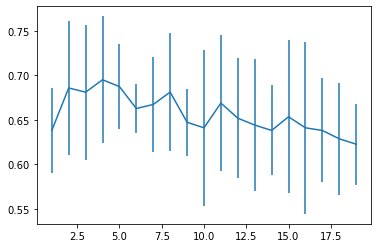

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.errorbar(depth_acc[:,0], depth_acc[:,1], yerr = depth_acc[:,2])
plt.show()